# 04 - Análise de Tendência: Mann-Kendall e Sen’s Slope

Este notebook aplica o **teste de Mann-Kendall** e o cálculo da **inclinação de Sen** em cada pixel do NEB, usando como entradas:
- Frequência anual e sazonal (EPI, EPF, EPN)

- Intensidade anual e sazonal (EPI, EPF, EPN)

A abordagem é **vetorizada** para eficiência:  

- Os cálculos são feitos em matrizes completas usando `numpy`.  

- Evita loops Python pixel a pixel (muito lentos para dados CHIRPS).


## Importações e parâmetros

In [11]:
import xarray as xr
import numpy as np
import os
from scipy.stats import kendalltau
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# Diretórios
base_dir = "dataset/netcdf_data/freq_intensidade"
saida_dir = "dataset/netcdf_data/tendencia"
os.makedirs(saida_dir, exist_ok=True)

## Funções

### Mann-Kendall Simplificado

O teste Mann-Kendall verifica a tendência monotônica:

* **S**: soma de sinais (par positivo ou negativo).

* **Var(S)**: variância.

* **Z**: estatística padronizada.

In [3]:
def mann_kendall_test(data):
    """
    data: array (tempo, n_pixels)
    Retorna: Z-statistic por pixel
    """
    n = data.shape[0]
    # Combinações par a par
    s = np.sign(data[None,:,:] - data[:,None,:])  # (tempo, tempo, pixel)
    s = np.triu(s, k=1)  # só parte superior da matriz
    s_sum = np.sum(s, axis=(0,1))
    var_s = n*(n-1)*(2*n+5)/18
    z = np.where(s_sum > 0,
                 (s_sum-1)/np.sqrt(var_s),
                 np.where(s_sum < 0,
                          (s_sum+1)/np.sqrt(var_s),
                          0))
    return z


**Sen’s Slope**

Inclinação mediana entre todos os pares.

In [4]:
def sens_slope(data, anos):
    """
    data: array (tempo, n_pixels)
    anos: vetor com anos (mesmo comprimento que tempo)
    Retorna: slope por pixel (mm/ano ou contagem/ano)
    """
    n = len(anos)
    slopes = []
    for i in range(n-1):
        diff = (data[i+1:,:] - data[i,:]) / (anos[i+1:] - anos[i])[:, None]
        slopes.append(diff)
    slopes = np.concatenate(slopes, axis=0)
    return np.median(slopes, axis=0)


## Carregar e processar dados

Para não repetir o mesmo código para cada variável, criamos uma função que:

1. Recebe o caminho de um arquivo NetCDF (frequência ou intensidade de EPI/EPN/EPF, anual ou sazonal).

2. Calcula a estatística Z do teste Mann-Kendall e a inclinação de Sen.

3. Calcula o **p-valor** a partir do Z (teste bicaudal) e gera um **mapa binário de significância** (`1` = significativo a 95%, `0` = não significativo).

4. Salva três arquivos de saída:
   - `z_...nc` (Z-statistic)

   - `slope_...nc` (Sen’s slope)
   
   - `sig_...nc` (mapa de significância binário)

Essa função será chamada em loop para **todas as combinações**:

- **Variáveis**: frequência e intensidade

- **Eventos**: EPI, EPN, EPF

- **Escalas**: anual e sazonal


In [13]:
def processar_mk_sen(arquivo_nc, saida_dir):
    """
    Aplica Mann-Kendall e Sen's slope a um arquivo NetCDF e salva resultados.
    """
    # Nome base para salvar
    nome_base = os.path.splitext(os.path.basename(arquivo_nc))[0]
    
    # Carregar dados
    da = xr.open_dataarray(arquivo_nc)
    anos = da.year.values if "year" in da.dims else np.arange(da.shape[0])  # anual ou sazonal
    
    # Reformatar (tempo, pixels)
    dados = da.values.reshape(len(anos), -1)
    
    # Calcular MK (Z)
    z = mann_kendall_test(dados)
    
    # Calcular Sen's slope
    slope = sens_slope(dados, anos)
    
    # Calcular p-valor (teste bicaudal)
    pval = 2 * (1 - norm.cdf(np.abs(z)))
    
    # Mapa de significância (p < 0.05)
    sig = (pval < 0.05).astype(int)
    
    # Reconstruir para grade espacial
    template = da.isel({list(da.dims)[0]: 0})  # usa primeira fatia para formato
    z_map = template.copy(deep=True)
    z_map.values = z.reshape(template.shape)
    
    slope_map = template.copy(deep=True)
    slope_map.values = slope.reshape(template.shape)
    
    sig_map = template.copy(deep=True)
    sig_map.values = sig.reshape(template.shape)
    
    # Salvar
    z_map.to_netcdf(os.path.join(saida_dir, f"z_{nome_base}.nc"))
    slope_map.to_netcdf(os.path.join(saida_dir, f"slope_{nome_base}.nc"))
    sig_map.to_netcdf(os.path.join(saida_dir, f"sig_{nome_base}.nc"))
    
    print(f"Processado: {nome_base}")


## Loop para todas as combinações

In [14]:
# Lista de arquivos no diretório freq_intensidade
arquivos = sorted([os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.endswith(".nc")])

for arq in arquivos:
    processar_mk_sen(arq, saida_dir)


/tmp/ipykernel_38104/633999135.py:5: SerializationWarning: saving variable precip with floating point data as an integer dtype without any _FillValue to use for NaNs
  processar_mk_sen(arq, saida_dir)
/tmp/ipykernel_38104/633999135.py:5: SerializationWarning: saving variable precip with floating point data as an integer dtype without any _FillValue to use for NaNs
  processar_mk_sen(arq, saida_dir)


Processado: freq_epf_anual
Processado: freq_epf_sazonal


/tmp/ipykernel_38104/633999135.py:5: SerializationWarning: saving variable precip with floating point data as an integer dtype without any _FillValue to use for NaNs
  processar_mk_sen(arq, saida_dir)
/tmp/ipykernel_38104/633999135.py:5: SerializationWarning: saving variable precip with floating point data as an integer dtype without any _FillValue to use for NaNs
  processar_mk_sen(arq, saida_dir)


Processado: freq_epi_anual
Processado: freq_epi_sazonal


/tmp/ipykernel_38104/633999135.py:5: SerializationWarning: saving variable precip with floating point data as an integer dtype without any _FillValue to use for NaNs
  processar_mk_sen(arq, saida_dir)
/tmp/ipykernel_38104/633999135.py:5: SerializationWarning: saving variable precip with floating point data as an integer dtype without any _FillValue to use for NaNs
  processar_mk_sen(arq, saida_dir)


Processado: freq_epn_anual
Processado: freq_epn_sazonal
Processado: int_epf_anual
Processado: int_epf_sazonal
Processado: int_epi_anual
Processado: int_epi_sazonal
Processado: int_epn_anual
Processado: int_epn_sazonal


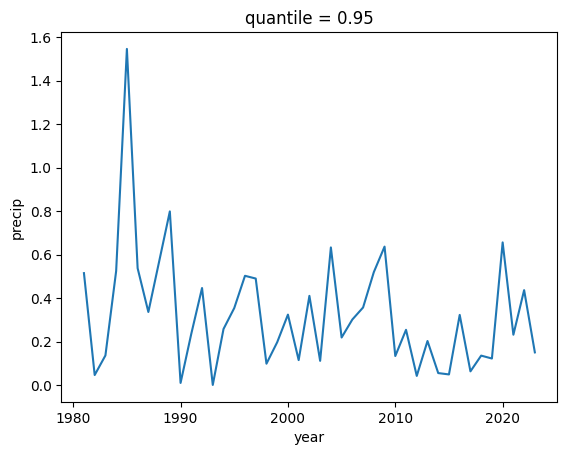

In [16]:
freq_epi_anual.mean(dim=("lat","lon")).plot()

In [17]:
print(freq_epi_anual.shape)  # Deve ser (anos, lat, lon)
print(freq_epi_anual.isel(year=0))  # Visualizar mapa de 1 ano


(43, 267, 188)
<xarray.DataArray 'precip' (lat: 267, lon: 188)> Size: 201kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(267, 188), dtype=int32)
Coordinates:
  * lat       (lat) float64 2kB -2.75 -2.8 -2.85 -2.9 ... -15.95 -16.0 -16.05
  * lon       (lon) float64 2kB -44.55 -44.5 -44.45 -44.4 ... -35.3 -35.25 -35.2
    year      int32 4B 1981
    quantile  float64 8B ...


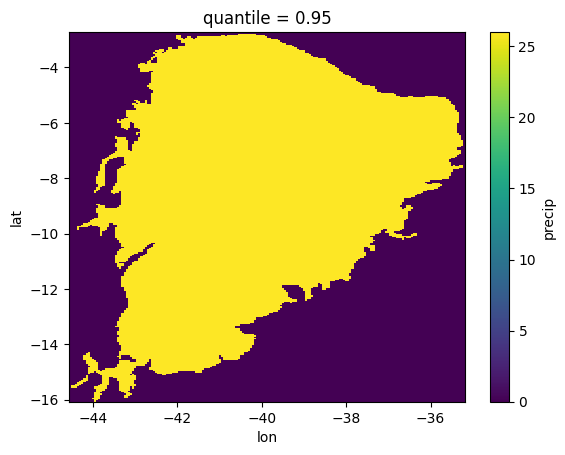

In [18]:
freq_epi_anual.sum(dim="year").plot()


In [19]:
print(np.unique(freq_epi_anual.values))

[0 1 2 3 4 5 6]


## Validação rápida (plot exemplo)

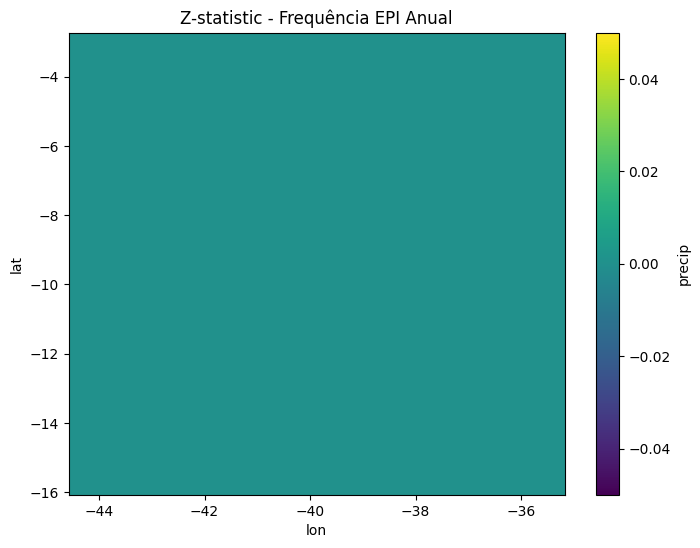

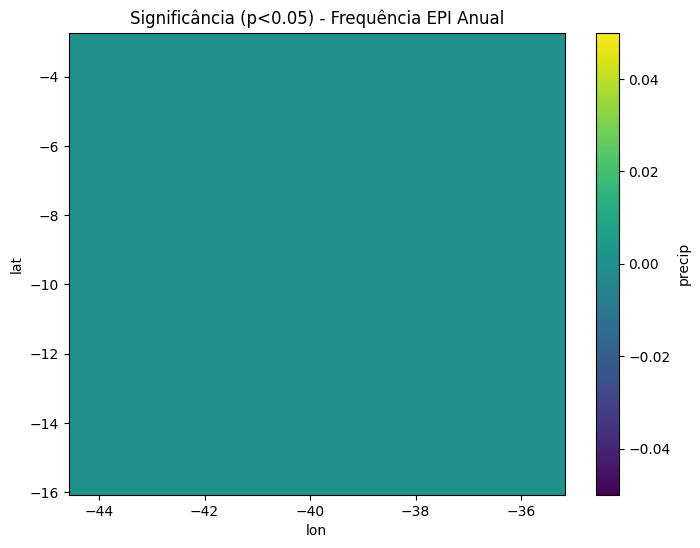

In [15]:
# Plotar um exemplo: Z e significância para freq_epi_anual
ex_z = xr.open_dataarray(os.path.join(saida_dir, "z_freq_epi_anual.nc"))
ex_sig = xr.open_dataarray(os.path.join(saida_dir, "sig_freq_epi_anual.nc"))

ex_z.plot(figsize=(8,6))
plt.title("Z-statistic - Frequência EPI Anual")
plt.show()

ex_sig.plot(figsize=(8,6))
plt.title("Significância (p<0.05) - Frequência EPI Anual")
plt.show()
